<a href="https://colab.research.google.com/github/marchaem/causal-inference/blob/master/CausalML_causal_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color=Darkred>Causal inference in observational data</font>
---


## <font color=Darkblue>Identifying the impact of an email marketing campaign.  </font>

> Hillstrom, K. (2008) __The MineThatData e-mail analytics and data mining challenge__. [MineThatData blog](http://blog.minethatdata.com/2008/03/minethatdata-e-mail-analytics-and-data.html). Accessed 15 October 2019.

<br>

Install [`causalml`](https://github.com/uber/causalml): a `python` package for uplift modeling and causal inference with machine learning.
<br> 


![](https://neurohive.io/wp-content/uploads/2019/08/Snimok-ekrana-2019-08-30-v-23.43.23.png)

Essentially, it estimates the causal impact of intervention __T__ on outcome __Y__ for users with observed features __X__,
without strong assumptions on the model form.

In [1]:
# Git clone the Guthub repository
!git clone https://github.com/uber/causalml

Cloning into 'causalml'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 938 (delta 30), reused 18 (delta 2), pack-reused 869
Receiving objects: 100% (938/938), 12.32 MiB | 11.44 MiB/s, done.
Resolving deltas: 100% (554/554), done.


In [2]:
#Install the package requirements first
!pip install -r /content/causalml/requirements.txt

     |████████████████████████████████| 24.8MB 1.2MB/s 
     |████████████████████████████████| 12.8MB 47.7MB/s 
     |████████████████████████████████| 5.4MB 51.8MB/s 
     |████████████████████████████████| 114.0MB 1.2MB/s 
     |████████████████████████████████| 112kB 57.6MB/s 
     |████████████████████████████████| 266kB 59.2MB/s 
  Created wheel for shap: filename=shap-0.31.0-cp36-cp36m-linux_x86_64.whl size=375009 sha256=1a92c61b0475b09e18d2fe9a3240254c84371d45bf294aa85895f5a5beaaf02d
  Stored in directory: /root/.cache/pip/wheels/7b/2d/46/ff8959add2e4e99a18a6e90b82f47508bf52fdf7e7d806f7df
Successfully built shap
ERROR: plotnine 0.5.1 has requirement matplotlib>=3.0.0, but you'll have matplotlib 2.2.4 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.3.1
    Uninstalling scipy-1.3.1:
      Successfully uninstalled scipy-1.3.1
  Found existing install

After this step, restart the runtype: __Runtime -> Restart runtime...__

<br>

Also, install other required packages.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<br>

### <font color=Darkred>1. The dataset</font>

This dataset contains __64,000__ customers who last purchased within twelve months. The customers were involved in an e-mail test.
* 1/3 were randomly chosen to receive an e-mail campaign featuring Mens merchandise.
* 1/3 were randomly chosen to receive an e-mail campaign featuring Womens merchandise.
* 1/3 were randomly chosen to not receive an e-mail campaign.

<br>
During a period of two weeks following the e-mail campaign, results were tracked. Your job is to tell the world if the Mens or Womens e-mail campaign was successful.

Historical customer attributes at your disposal include:
* Recency: Months since last purchase.
* History_Segment: Categorization of dollars spent in the past year.
* History: Actual dollar value spent in the past year.
* Mens: 1/0 indicator, 1 = customer purchased Mens merchandise in the past year.
* Womens: 1/0 indicator, 1 = customer purchased Womens merchandise in the past year.
* Zip_Code: Classifies zip code as Urban, Suburban, or Rural.
* Newbie: 1/0 indicator, 1 = New customer in the past twelve months.
* Channel: Describes the channels the customer purchased from in the past year.
* Segment: describes the e-mail campaign the customer received: Mens E-Mail, Womens E-Mail or No E-Mail.

<br>
Finally, we have a series of variables describing activity in the two weeks following delivery of the e-mail campaign:

* Visit: 1/0 indicator, 1 = Customer visited website in the following two weeks.
* Conversion: 1/0 indicator, 1 = Customer purchased merchandise in the following two weeks.
* Spend: Actual dollars spent in the following two weeks.

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving MIneThatData_raw.csv to MIneThatData_raw.csv
User uploaded file "MIneThatData_raw.csv" with length 3900976 bytes


In [5]:
df=pd.read_csv('MIneThatData_raw.csv', delimiter=',').drop(columns=['history_segment'])
print('Number of rows and columns:', df.shape)
print('Data types:', df.dtypes)
df.head(5)

Number of rows and columns: (64000, 11)
Data types: recency         int64
history       float64
mens            int64
womens          int64
zip_code       object
newbie          int64
channel        object
segment        object
visit           int64
conversion      int64
spend         float64
dtype: object


,recency,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


<br>

### <font color=Darkred>2. Descriptive analysis</font>

In [6]:
# To produce a table with the desc stats of the variables of interest
df[['segment','spend','visit','conversion']].groupby('segment').describe().round(2).T

segment           Mens E-Mail  No E-Mail  Womens E-Mail
spend      count     21307.00   21306.00       21387.00
           mean          1.42       0.65           1.08
           std          17.75      11.59          15.12
           min           0.00       0.00           0.00
           25%           0.00       0.00           0.00
           50%           0.00       0.00           0.00
           75%           0.00       0.00           0.00
           max         499.00     499.00         499.00
visit      count     21307.00   21306.00       21387.00
           mean          0.18       0.11           0.15
           std           0.39       0.31           0.36
           min           0.00       0.00           0.00
           25%           0.00       0.00           0.00
           50%           0.00       0.00           0.00
           75%           0.00       0.00           0.00
           max           1.00       1.00           1.00
conversion count     21307.00   21306.00       21387.00
           mean          0.01       0.01           0.01
           std           0.11       0.08           0.09
           min           0.00       0.00           0.00
           25%           0.00       0.00           0.00
           50%           0.00       0.00           0.00
           75%           0.00       0.00           0.00
           max           1.00       1.00           1.00

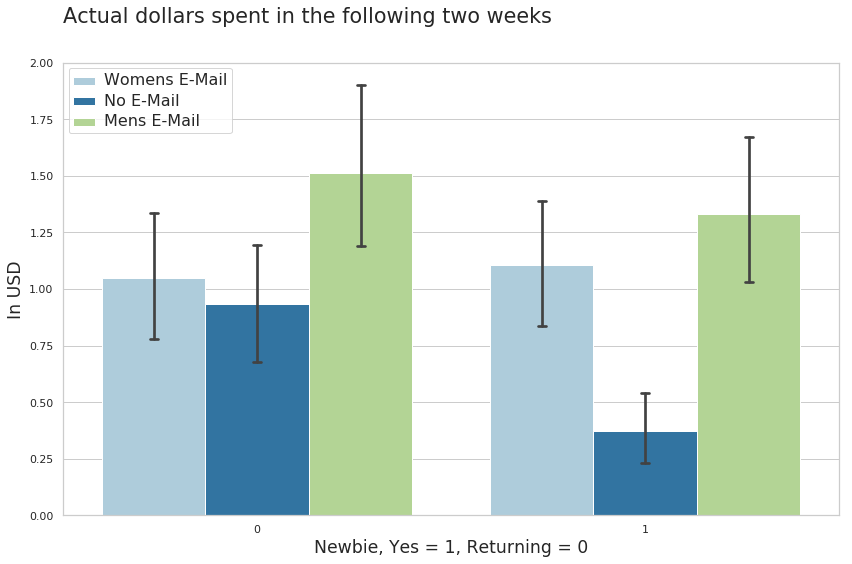

In [7]:

# Initialize the plot
plt.figure(figsize=(12,8))

# Plots
sns.set(style="whitegrid")
graph1 = sns.barplot(x="newbie", y="spend", hue="segment", data=df, 
                     capsize=.02, palette="Paired")

# Further customize
plt.xlabel('Newbie, Yes = 1, Returning = 0', size = 'x-large')
plt.ylim(0, 2 )
plt.ylabel('In USD', size = 'x-large') 
plt.legend(loc= 'upper left');
plt.setp(graph1.get_legend().get_texts(), fontsize='16') # for legend text
plt.title('Actual dollars spent in the following two weeks', 
          loc = "left", size = 'xx-large', pad = 40)
plt.tight_layout();

We still have to one-hot-encode the categorical variables.

In [0]:
# This hot-encodes the categorical variables. 
# To drop the first label category ("dummy variable trap"), use drop_first = True
df = pd.get_dummies(df, drop_first=False)
df.head(5)

#### <font color=Darkred>2.1 Summary statistics</font>


In [8]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
recency,64000.0,5.76,3.51,1.00,2.00,6.00,9.00,12.00
history,64000.0,242.09,256.16,29.99,64.66,158.11,325.66,3345.93
mens,64000.0,0.55,0.50,0.00,0.00,1.00,1.00,1.00
womens,64000.0,0.55,0.50,0.00,0.00,1.00,1.00,1.00
newbie,64000.0,0.50,0.50,0.00,0.00,1.00,1.00,1.00
visit,64000.0,0.15,0.35,0.00,0.00,0.00,0.00,1.00
conversion,64000.0,0.01,0.09,0.00,0.00,0.00,0.00,1.00
spend,64000.0,1.05,15.04,0.00,0.00,0.00,0.00,499.00


<br>
Let's inspect the distribution of how much these customers spend in the last year (variable = history).

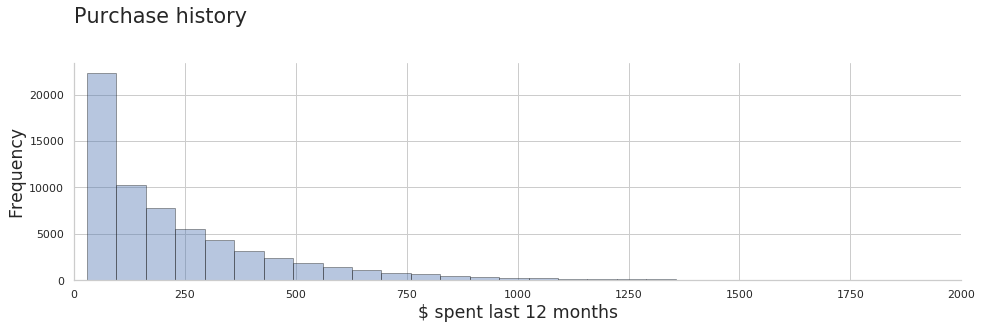

In [9]:
# Initialize the plot
plt.figure(figsize=(35,4))

# Create a histogram to observe the distribution of 'history' ($ spent last year)
plt.subplot(1,2,1)
sns.distplot(df['history'], kde = False, norm_hist = False, 
             hist_kws=dict(edgecolor="k", linewidth=1))
sns.despine(top=True, right=True, left=False, bottom=False)

# Further customize
plt.title('Purchase history', loc = "left", size = 'xx-large', pad = 40)
plt.xlabel('$ spent last 12 months', size = 'x-large')
plt.xlim(0, 2000)
plt.ylabel('Frequency', size = 'x-large');

<br>
Let's inspect the distribution of recency.

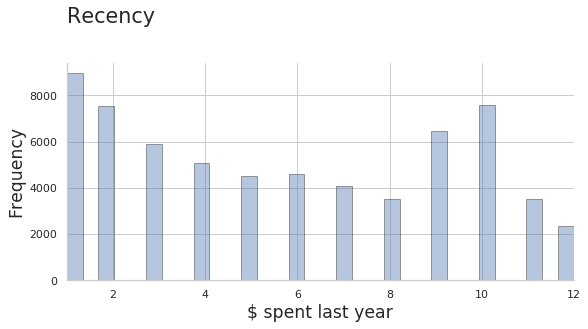

In [10]:
# Initialize the plot
plt.figure(figsize=(20,4))

# Create a histogram to observe the distribution of 'recency' (in months)
plt.subplot(1,2,1)
sns.distplot(df['recency'], kde = False, norm_hist = False, 
             hist_kws=dict(edgecolor="k", linewidth=1))
sns.despine(top=True, right=True, left=False, bottom=False)

# Further customize
plt.title('Recency', loc = "left", size = 'xx-large', pad = 40)
plt.xlabel('$ spent last year', size = 'x-large')
plt.xlim(1, 12)
plt.ylabel('Frequency', size = 'x-large');

<br>

### <font color=Darkred>3. Causal inference</font>

In [11]:
# Install Causal ML
!pip install causalml

     |████████████████████████████████| 143kB 9.2MB/s 
  Created wheel for causalml: filename=causalml-0.4.0-cp36-cp36m-linux_x86_64.whl size=227102 sha256=f8fd772b1840bfaed62693fd3ddd434268ddda4cbb2e742fca961ec3cb847a47
  Stored in directory: /root/.cache/pip/wheels/1d/05/e6/783812f61df1a80fbc70eb619d5b859b795e053ee7d9e02901
Successfully built causalml


In [12]:
# Install/import other required packages
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *

import causalml
print(causalml.__version__)

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

Using TensorFlow backend.


0.4.0


<br>

Uber’s [CausalML](https://causalml.readthedocs.io/en/latest/about.html) is a Python-based library for __causal inference__. 

It provides a standard interface that allows user to estimate the __Conditional Average Treatment Effect (CATE)__ from experimental or observational data.

<br>

Typical use cases include:

* __Campaign Targeting Optimization:__ An important lever to increase ROI in an advertising campaign is to target the ad to the set of customers who will have a favorable response in a given KPI such as engagement or sales. CATE identifies these customers by estimating the effect of the KPI from ad exposure at the individual level from A/B experiment or historical observational data.
* __Personalized Engagement:__ Company has multiple options to interact with its customers such as different product choices in up-sell or mess aging channels for communications. One can use CATE to estimate the heterogeneous treatment effect for each customer and treatment option combination for an optimal personalized recommendation system.


We first estimate the Average Treatment Effect (ATE) with S, T, X, and R Learners. A meta-algorithm (or meta-learner) is a framework to estimate the Conditional Average Treatment Effect (CATE) using any machine learning estimators (called base learners).

<br>

For this, we need to define the outcome of interest (spend) as __y__, the treatment (Men's or Women's email) as __treatment__, and the set of covariates __X__.

Let's start by estimating the effect of the __Women's email campaign__.

In [0]:
# Create dataframe containing cases the observations in the control group (no email) and women's email.
women_df = df.loc[df['segment_Mens E-Mail'] != 1] # != is not equal
women_df.shape

# All the observations containing cases in which a Men's email was sent are dropped.

In [0]:
# Visualize the average difference between the two groups in the outcomes.
women_df[['segment_Womens E-Mail','spend','visit','conversion']].groupby('segment_Womens E-Mail').describe().round(2).T

In [0]:
# Declare the treatement indicator variable
womens_email = women_df.loc[:, "segment_Womens E-Mail"].to_numpy()
womens_email.shape

In [0]:
# Declare the set of covariates
X = women_df.loc[:, ["recency","history","mens","womens","newbie",
                     "zip_code_Rural","zip_code_Surburban", 
                     "channel_Phone","channel_Web"]].to_numpy()
X.shape

In [0]:
# The outcome of interest will be called - women_spend -
womens_spend = women_df.loc[:,"spend"].to_numpy()
womens_spend.shape


<br>

#### <font color=Darkred>3.1 Estimation of the ATE using Meta_Learners (*S, T, X, R*)
</font>

In [0]:
# S-learner
lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(X, womens_email, womens_spend)
print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

In [0]:
# T-learner
xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, womens_email, womens_spend)
print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

In [0]:
# The X-learner and R-learner require a propensity score
from causalml.propensity import ElasticNetPropensityModel
pm = ElasticNetPropensityModel(n_fold=5, random_state=42)
ps = pm.fit_predict(X, womens_email)

In [0]:
# X-learner
xl = BaseXRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub = xl.estimate_ate(X, ps, womens_email, womens_spend)
print('Average Treatment Effect (BaseXRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

In [0]:
# R-learner
rl = BaseRRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub =  rl.estimate_ate(X, ps, womens_email, womens_spend)
print('Average Treatment Effect (BaseRRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

<br>

#### <font color=Darkred>3.2 Calculate conditional ATE using Meta_Learners (*S, T, X, R*)
</font>

In [0]:
# S Learner
learner_s = LRSRegressor()
cate_s = learner_s.fit_predict(X, womens_email, womens_spend)

# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
cate_t = learner_t.fit_predict(X, womens_email, womens_spend)

# X Learner
learner_x = BaseXRegressor(learner=XGBRegressor())
cate_x = learner_x.fit_predict(X, ps, womens_email, womens_spend)

# R Learner
learner_r = BaseRRegressor(learner=XGBRegressor())
cate_r = learner_r.fit_predict(X, ps, womens_email, womens_spend)

<br>
Let's plot the predicted CATE.

In [0]:
# Initialize plot
alpha=0.2
bins=5000
plt.figure(figsize=(12,8))

# Plot the histograms of the predictions by Learner
plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')
plt.vlines(cate_s[0], 0, plt.axes().get_ylim()[1], label='S Learner',
           linestyles='dotted', colors='green', linewidth=2)

# Further customize
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.xlim(-3, 3)
plt.ylabel('# of Samples')
_=plt.legend()

<br>

### <font color=Darkred>4. Discussion of the results</font>

The winning solution for the challenge was submitted by Nicolas Radcliffe of [Stochastic Solutions](http://stochasticsolutions.com/).

His paper is titled, "[Hillstrom’s MineThatData Email Analytics Challenge: An Approach Using Uplift Modelling](http://minethatdata.com/Stochastic_Solutions_E-Mail_Challenge_2008.04.30.pdf)".

Among their main results about the women's email campaign:

* The campaign had a positive impact overall;

* There are some segments for which the Women’s mailing, in particular, appeared to reduce rather than increase spending; 

* An extremely small number of people were responsible for over half of the incremental spend.